In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as la

from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import noise
from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2, FakeAthensV2, FakeAthens

# Homemade imports
from qiskit_algorithms import VarQITE, TimeEvolutionProblem, VarQRTE
from qiskit_algorithms.gradients import LinCombEstimatorGradient, LinCombQGT
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple, RealMcLachlanPrinciple
#import qiskit_algorithms.time_evolvers.variational.variational_principles.imaginary_mc_lachlan_principle as mc_lachlan
import qiskit.primitives.utils as utils

from qiskit.primitives import Estimator
from qiskit.primitives import BackendEstimator, BackendEstimatorV2
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector

from qiskit_algorithms import SciPyRealEvolver


In [2]:
# Hamiltonian reading, TC
data = np.loadtxt('qubit_hamil_h2.txt', dtype=str) # H2, 0.7A sto6g
paulistrings = data[:,0] 
coefficients = (data[:,1])
#coefficients = [np.real(complex(coeff)) for coeff in coefficients]
coefficiencts = [complex(coeff) for coeff in coefficients]
paulis = list(zip(paulistrings, coefficients))
qubit_op = SparsePauliOp.from_list(paulis)
qubit_op = qubit_op.adjoint()
print(qubit_op)

# No TC Hamiltonian
driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.7",
    unit=DistanceUnit.ANGSTROM,
    charge=0,
    spin=0,
    basis='sto6g'
)
problem = driver.run()
h = problem.hamiltonian.second_q_op()

# Mapper
mapper = ParityMapper(num_particles = problem.num_particles)
qubit_op2 = mapper.map(h)
print(qubit_op2)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XY', 'YX', 'XX'],
              coeffs=[-1.09284335-0.j        ,  0.42027207-0.j        , -0.42027207-0.j        ,
 -0.01086588-0.j        ,  0.        -0.06359682j,  0.        +0.06359682j,
  0.1576953 -0.j        ])
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05178903+0.j,  0.4209349 +0.j, -0.4209349 +0.j, -0.01159108+0.j,
  0.17928567+0.j])


In [3]:
# Settings for all estimators
numshots = 1000000000
seed = 170

# Simple noise model with depolarizing error
prob_1 = 0.0001   # 1-qubit gate
prob_2 = 0.0001   # 2-qubit gate
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Estimators
estimator = Estimator(options={'seed': seed})
shot_estimator = Estimator(options={'seed': seed, 'shots': numshots})
noisy_estimator = AerEstimator(
    backend_options={
        "noise_model": noise_model, 
        # Disabling noise_model but having shotnoise means it runs only ONCE. 
    },
    run_options={"seed": seed, "shots": numshots},       
    transpile_options={"seed_transpiler": seed},       
    approximation=True                                 
)

#backend_estimator = BackendEstimator(options={"seed": seed, "numshots": numshots}, backend=FakeAthens())
#backend_estimator = BackendEstimator(backend=FakeAthens())
backend_estimator = BackendEstimator(backend=FakeAthensV2())
# backend_estimator = BackendEstimatorV2(backend=FakeAthensV2()) # Won't work, Qiskit Algorithms doesn't support it in current version


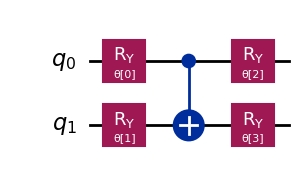

In [4]:
# Ansatz

# UCCSD
initial_circuit = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)
ansatz = UCCSD(num_spatial_orbitals = problem.num_spatial_orbitals, num_particles = problem.num_particles, qubit_mapper=mapper, initial_state=initial_circuit)
init_param_values = [0 for _ in range(ansatz.num_parameters)]
ansatz.decompose().decompose().draw("mpl")


# EfficientSU2
ansatz = EfficientSU2(num_qubits = qubit_op2.num_qubits, reps=1, su2_gates=["ry"])#, skip_final_rotation_layer=True)
init_param_values = [np.pi,np.pi,0,0]
ansatz.decompose().draw("mpl")


In [5]:
# Testing the initial state
print(ansatz.num_parameters)
state = Statevector.from_int(0, 2**qubit_op.num_qubits)
test_circ = ansatz.assign_parameters(init_param_values)
state = state.evolve(test_circ)
state.draw('latex')

4


<IPython.core.display.Latex object>

In [6]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(estimator), 
                                                       gradient=LinCombEstimatorGradient(estimator), 
                                                       non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result = qite.evolve(time_evo)

Getting QNG
Getting gradient
Next param set is [ 6.10033266e-02  1.52174605e-16  1.28883868e-17 -1.52174605e-16]
Getting QNG
Getting gradient
Next param set is [ 5.07423240e-02 -6.16499087e-17  4.95937490e-17  6.13462251e-17]
Getting QNG
Getting gradient
Next param set is [ 4.21985959e-02  1.42255105e-16  2.10845390e-17 -1.42481829e-16]
Getting QNG
Getting gradient
Next param set is [ 3.50875908e-02 -6.19612129e-17 -8.84731939e-18  6.20900651e-17]
Getting QNG
Getting gradient
Next param set is [ 2.91709510e-02 -6.18264853e-17 -1.02480671e-17  6.20091489e-17]
Getting QNG
Getting gradient
Next param set is [ 2.42493429e-02  1.52023548e-16 -8.92818408e-18 -1.51792558e-16]
Getting QNG
Getting gradient
Next param set is [ 2.01562827e-02 -6.25708847e-17  4.52559015e-17  6.14553636e-17]
Getting QNG
Getting gradient
Next param set is [ 1.67528627e-02 -6.28400334e-17  3.57434245e-17  6.18798219e-17]
Getting QNG
Getting gradient
Next param set is [ 1.39232766e-02 -6.31422610e-17  2.98737575e-17 

In [7]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code, with shot noise.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(shot_estimator), 
                                                       gradient=LinCombEstimatorGradient(shot_estimator), 
                                                       non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=shot_estimator, 
               num_timesteps=num_timesteps)
result_shotnoise = qite.evolve(time_evo)

Getting QNG
Getting gradient
Next param set is [ 6.10347092e-02  3.06752270e-05  8.17852691e-05 -2.17445559e-05]
Getting QNG
Getting gradient
Next param set is [ 5.07684387e-02  2.65681990e-05  7.53988403e-05 -1.96077611e-05]
Getting QNG
Getting gradient
Next param set is [ 4.22203177e-02  2.30410755e-05  6.94028579e-05 -1.76518777e-05]
Getting QNG
Getting gradient
Next param set is [ 3.51056527e-02  2.00042978e-05  6.38024658e-05 -1.58652557e-05]
Getting QNG
Getting gradient
Next param set is [ 2.91859655e-02  1.73831652e-05  5.85928263e-05 -1.42364752e-05]
Getting QNG
Getting gradient
Next param set is [ 2.42618215e-02  1.51153891e-05  5.37624198e-05 -1.27544038e-05]
Getting QNG
Getting gradient
Next param set is [ 2.01666519e-02  1.31489720e-05  4.92954074e-05 -1.14082649e-05]
Getting QNG
Getting gradient
Next param set is [ 1.67614778e-02  1.14404123e-05  4.51733167e-05 -1.01877015e-05]
Getting QNG
Getting gradient
Next param set is [ 1.39304336e-02  9.95321056e-06  4.13762408e-05 

In [8]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code, with noise model.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(noisy_estimator), 
                                                       gradient=LinCombEstimatorGradient(noisy_estimator), 
                                                       non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=noisy_estimator, 
               num_timesteps=num_timesteps)
result_noise = qite.evolve(time_evo)

Getting QNG
Getting gradient
Next param set is [ 6.09948338e-02  2.57246793e-05  6.63166608e-05 -1.67910958e-05]
Getting QNG
Getting gradient
Next param set is [ 5.07388477e-02  2.22529562e-05  6.11009028e-05 -1.52020082e-05]
Getting QNG
Getting gradient
Next param set is [ 4.21986937e-02  1.92758586e-05  5.62079356e-05 -1.37356953e-05]
Getting QNG
Getting gradient
Next param set is [ 3.50901603e-02  1.67165042e-05  5.16418965e-05 -1.23866646e-05]
Getting QNG
Getting gradient
Next param set is [ 2.91751575e-02  1.45107995e-05  4.73984323e-05 -1.11489644e-05]
Getting QNG
Getting gradient
Next param set is [ 2.42545618e-02  1.26053345e-05  4.34675758e-05 -1.00163322e-05]
Getting QNG
Getting gradient
Next param set is [ 2.01620526e-02  1.09555555e-05  3.98357854e-05 -8.98233704e-06]
Getting QNG
Getting gradient
Next param set is [ 1.67588489e-02  9.52422010e-06  3.64873867e-05 -8.04050529e-06]
Getting QNG
Getting gradient
Next param set is [ 1.39292414e-02  8.28011031e-06  3.34055859e-05 

In [9]:
###############
### VarQITE ###
###############
# This is the TC Hamiltonian with the modified code, with the backend.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(backend_estimator), 
                                                       gradient=LinCombEstimatorGradient(backend_estimator), 
                                                       non_hermitian=True)
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=backend_estimator, 
               num_timesteps=num_timesteps)
result_backend = qite.evolve(time_evo)

Getting QNG


In [10]:
###############
### VarQITE ###
###############
# This is the non-TC Hamiltonian with the backend.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(backend_estimator), gradient=LinCombEstimatorGradient(backend_estimator))
time_evo = TimeEvolutionProblem(qubit_op2, 
                                time=total_time, 
                                aux_operators=[qubit_op2])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=backend_estimator, 
               num_timesteps=num_timesteps)
result_backend2 = qite.evolve(time_evo)

Getting QNG


In [11]:
###############
### VarQITE ###
###############
# This is the non-TC Hamiltonian.

# The 2 main tunable parameters
total_time=5
num_timesteps = 50

var_principle = ImaginaryMcLachlanPrinciple(qgt=LinCombQGT(estimator), gradient=LinCombEstimatorGradient(estimator))
time_evo = TimeEvolutionProblem(qubit_op2, 
                                time=total_time, 
                                aux_operators=[qubit_op2])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result2 = qite.evolve(time_evo)

Getting QNG
Getting gradient
Next param set is [ 3.58571342e-01  1.49922041e-16 -1.58017993e-17 -1.49922041e-16]
Getting QNG
Getting gradient
Next param set is [ 2.97979713e-01 -5.92415325e-17  2.38321409e-17  5.83490830e-17]
Getting QNG
Getting gradient
Next param set is [ 2.47332094e-01  9.39398914e-17  1.41576435e-17 -9.46663497e-17]
Getting QNG
Getting gradient
Next param set is [ 2.05124331e-01 -6.33846154e-17  3.29976237e-17  6.01473240e-17]
Getting QNG
Getting gradient
Next param set is [ 1.70023116e-01 -6.43331836e-17  6.16065486e-17  5.71197567e-17]
Getting QNG
Getting gradient
Next param set is [ 1.40873618e-01  1.40700949e-16 -3.45369613e-18 -1.39111105e-16]
Getting QNG
Getting gradient
Next param set is [ 1.16690422e-01 -6.25674033e-17  1.70622591e-18  6.16962883e-17]
Getting QNG
Getting gradient
Next param set is [ 9.66409121e-02 -6.71860348e-17  4.27584521e-17  5.98500057e-17]
Getting QNG
Getting gradient
Next param set is [ 8.00261880e-02  1.52212766e-16 -2.78857567e-17 

In [12]:
data = np.loadtxt("energy_trace_h2.dat")
avqite_times = data[:,0]
avqite_energies = data[:,2]
initial_time=data[0,0]
initial_energy=data[0,2]
#print(f"Initial time: {initial_time}, Initial energy: {initial_energy}")

E0_noisy: -1.922315151004349, E0_noTC: -1.8820677470371823, E0_TC: -1.9225216042673814


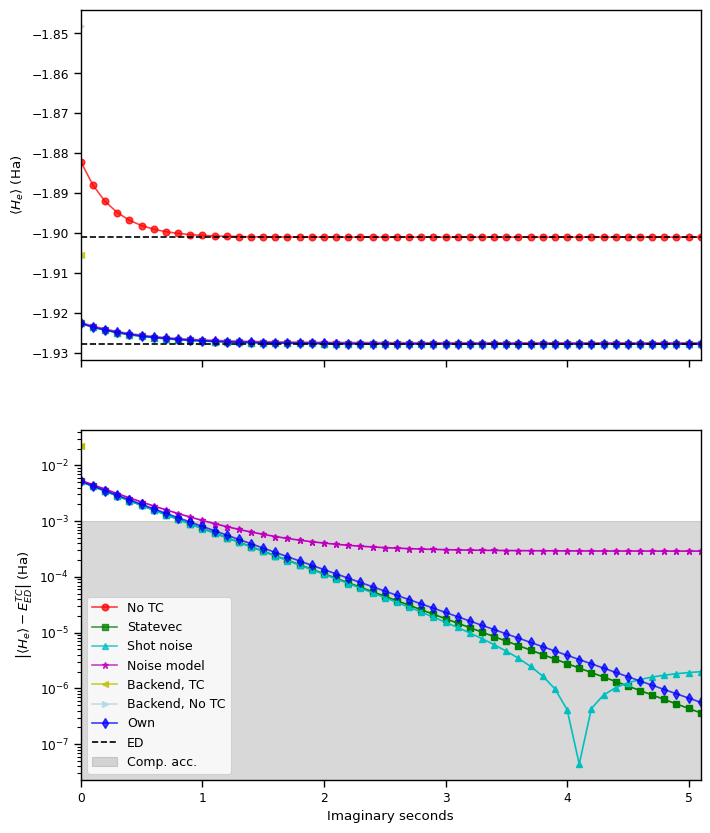

In [13]:
sns.set_context("paper")
fig, axs = plt.subplots(2,1,sharex=True)
fig.set_figheight(10)
fig.set_figwidth(8)
ax = axs[0]
ax2 = axs[1]
#DELTA_BIG = 50
DELTA_BIG = 2
sys = "h2"
e_exact = {"h2": -1.9276748321, "h4": -4.3860854160}
e_exact_notc = {"h2": -1.9009465237, "h4": None} 

h_exp_val = np.array([ele[0][0].real for ele in result.observables])
times = result.times
h_exp_val2 = np.array([ele[0][0].real for ele in result2.observables])
times2 = result2.times
h_exp_val_shotnoise = np.array([ele[0][0].real for ele in result_shotnoise.observables])
times_shotnoise = result_shotnoise.times
h_exp_val_noise = np.array([ele[0][0].real for ele in result_noise.observables])
times_noise = result_noise.times
h_exp_val_backend = np.array([ele[0][0].real for ele in result_backend.observables])
times_backend = result_backend.times
h_exp_val_backend2 = np.array([ele[0][0].real for ele in result_backend2.observables])
times_backend2 = result_backend2.times


print(f"E0_noisy: {h_exp_val_noise[0]}, E0_noTC: {h_exp_val2[0]}, E0_TC: {h_exp_val[0]}")

ax.plot(times2, h_exp_val2, '-ro', label= "No TC", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times, h_exp_val, '-gs', label= "Statevec", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times_shotnoise, h_exp_val_shotnoise, '-c^', label= "Shot noise", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times_noise, h_exp_val_noise, '-m*', label= "Noise model", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times_backend, h_exp_val_backend, '-y<', label= "Backend, TC", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(times_backend2, h_exp_val_backend2, '->', color="lightblue", label= "Backend, No TC", alpha=0.75) #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(avqite_times[::DELTA_BIG], avqite_energies[::DELTA_BIG], '-bd', label= "Own", alpha=0.75)
ax.plot([e_exact[sys]]*(int(times[-1])+15), '--k', label= "ED")
ax.plot([e_exact_notc[sys]]*(int(times[-1])+15), '--k')
ax.set_ylabel(r"$\langle H_e \rangle$ (Ha)")
#ax.legend()
ax.set_xlim([0, times[-1]])

#print(f"Final Qiskit electronic energy: {h_exp_val[-1]} Ha")
#print(f"Compare with Qutip ED: -4.3860854160 Ha")
#print(f"Compare with TC-VarQITE for UCCSD: -4.3860791082 Ha")


ax2.plot(times, abs(h_exp_val-e_exact[sys]), "-gs", label= "Statevec")
ax2.plot(times_shotnoise, abs(h_exp_val_shotnoise-e_exact[sys]), "-c^", label= "Shot noise")
ax2.plot(times_noise, abs(h_exp_val_noise-e_exact[sys]), "-m*", label= "Noise model")
ax2.plot(times_backend, abs(h_exp_val_backend-e_exact[sys]), "-y<", label= "Backend, TC")
ax2.plot(avqite_times[::DELTA_BIG], abs(avqite_energies-e_exact[sys])[::DELTA_BIG], "-bd", label= "Own", alpha=0.75)
ax2.fill_between([0,times[-1]],[1e-3,1e-3],color="grey",alpha=0.3,label="Comp. acc.")
ax2.set_xlabel("Imaginary seconds")
ax2.set_ylabel(r"$\left|\langle H_e \rangle - E_{ED}^{TC}\right|$ (Ha)")
ax2.set_yscale("log")
ax2.set_xlim([0, times[-1]])

h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
for index, label in enumerate(l2):
    if label not in l:
        l.append(label)
        h.append(h2[index])
ax2.legend(h, l, prop={'size': 9})
